# Working With Data Using ArcPy

### Describe Data

- Geoprocessing tools work with all types of data, such as geodatabase feature classes, shapefiles, rasters, tables, topologies, and networks
- Each data type has a unique set of properties
- [Help Document](https://pro.arcgis.com/en/pro-app/arcpy/get-started/describing-data.htm)

In [1]:
import arcpy
from arcpy import env
from arcpy import da

fgdb = r"./data/Water_And_Wetlands_5_1.gdb"
env.workspace = fgdb

for fc in arcpy.ListFeatureClasses():
    desc = da.Describe(fc)
    del fc

desc.keys()

dict_keys(['catalogPath', 'FIDSet', 'aliasName', 'areaFieldName', 'baseName', 'canVersion', 'changeTracked', 'children', 'childrenExpanded', 'createdAtFieldName', 'creatorFieldName', 'dataElementType', 'datasetType', 'dataType', 'defaultSubtypeCode', 'DSID', 'editedAtFieldName', 'editorFieldName', 'editorTrackingEnabled', 'extension', 'extensionProperties', 'extent', 'featureType', 'fields', 'file', 'fullPropsRetrieved', 'geometryStorage', 'globalIDFieldName', 'hasGlobalID', 'hasM', 'hasOID', 'hasSpatialIndex', 'hasZ', 'indexes', 'isCOGOEnabled', 'isTimeInUTC', 'isVersioned', 'lengthFieldName', 'metadataRetrieved', 'MExtent', 'modelName', 'name', 'OIDFieldName', 'path', 'rasterFieldName', 'relationshipClassNames', 'representations', 'shapeFieldName', 'shapeType', 'spatialReference', 'subtypeFieldName', 'versionedView', 'ZExtent'])

#### Example: Examine key/value

In [8]:
i = 0
for k in desc.keys():
    print(f"{k} in {desc[k]}")
    i += 1
    if i > 5:
        break

catalogPath in ./data/Water_And_Wetlands_5_1.gdb\Water_And_Wetlands_5_15
FIDSet in None
aliasName in 
areaFieldName in Shape_Area
baseName in Water_And_Wetlands_5_15
canVersion in False


## Advanced Cursors Usage

- da module provides `Search`, `Update` and `Insert` operations


## `SearchCursor` 

- Provides a read-only view of data
- returns a `tuple` of objects
- Geometry properties can be accessed by specifying the token `SHAPE@` syntax
- Supports the `with` syntax and `del` operation

In [10]:
with da.SearchCursor(desc['catalogPath'], "*") as cursor:
    print(cursor.fields)
    for row in cursor:
        del row
        break

('OBJECTID', 'Shape', 'Wat_Wet', 'Lake_Flag', 'Shape_Length', 'Shape_Area')
(1, (6425288.462564462, 1806646.6004759942), 'Freshwater Herbaceous Wetland', None, 1261.1088967278336, 19166.632797130384)


In [15]:
desc['OIDFieldName']

'OBJECTID'

### Exploding the Points

- Deconstruct a feature into its individual points or vertices

In [21]:
with da.SearchCursor(desc['catalogPath'], '*', 
                     where_clause=f"{desc['OIDFieldName']} = 2",
                     explode_to_points=True) as cursor:
    for row in cursor:
        print(row)
        del row

(2, (6420360.242410839, 1807341.6956742555), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420357.939922005, 1807339.148107171), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420316.243155003, 1807359.9964906722), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420264.697982505, 1807397.977057755), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420180.599397421, 1807441.3824827522), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420205.015359089, 1807498.352841258), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420264.697982505, 1807525.4820520878), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420310.817312837, 1807530.9075661749), 'Freshwater Herbaceous Wetland', None, 719.8567098187657, 31372.16821724419)
(2, (6420325.475091919, 180

### Return a Dictionary of Key/Value Pairs

- An optional expression that limits the records returned

In [30]:
fields = [fld.name for fld in desc['fields'] if fld.type.lower() != 'geometry']
fields.append("Shape@")
with da.SearchCursor(desc['catalogPath'], 
                     fields, 
                     where_clause=f"{desc['OIDFieldName']} = 2",
                     explode_to_points=False) as cursor:
    for row in cursor:
        row_dict = dict(zip(cursor.fields, row))
        print(row_dict)
        del row

{'OBJECTID': 2, 'Wat_Wet': 'Freshwater Herbaceous Wetland', 'Lake_Flag': None, 'Shape_Length': 719.8567098187657, 'Shape_Area': 31372.16821724419, 'Shape@': <Polygon object at 0x2875e87d8d0[0x2875c1b79e0]>}


### Using `ORDER BY` to Sort Data

- Only works on database data

In [83]:
fields = [fld.name for fld in desc['fields'] if fld.type.lower() != 'geometry']
fields.append("Shape@")
with da.SearchCursor(desc['catalogPath'], 
                     fields, 
                     where_clause=f"{desc['OIDFieldName']} in (2, 3, 4)",
                     sql_clause=(None, 'ORDER BY Shape_Length'),
                     explode_to_points=False) as cursor:
    for row in cursor:
        row_dict = dict(zip(cursor.fields, row))
        print(row_dict['Shape_Length'])
        del row

646.4984888549493
719.8567098187657
3368.263101804901


### Defining the Spatial Reference

- Modify spatial reference when reading the data

In [54]:
fields = [fld.name for fld in desc['fields'] if fld.type.lower() != 'geometry']
fields.append("Shape@")
print(f"Original Factory Code: {desc['spatialReference'].factoryCode}")
with da.SearchCursor(desc['catalogPath'], 
                     fields, 
                     where_clause=f"{desc['OIDFieldName']} in (2, 3, 4)",
                     sql_clause=(None, 'ORDER BY Shape_Length'),
                     explode_to_points=False,
                     spatial_reference=arcpy.SpatialReference(4326)) as cursor:
      for row in cursor:
        row_dict = dict(zip(cursor.fields, row))
        print(f"On the fly reprojection: {row_dict['Shape@'].spatialReference.factoryCode}")
        del row, row_dict
        break

Original Factory Code: 2226
On the fly reprojection: 4326


## `UpdateCursor`

- read-write access to records
- returns an iterator of lists
- Use the `for` loop and a `with` statement

In [64]:
fc = "./data/World_Cities.shp"
def rows_as_update_dicts(cursor):
    fields = cursor.fields
    for row in cursor:
        row_object = dict(zip(fields, row))
        yield row_object
        cursor.updateRow([row_object[fld] for fld in fields])

with da.UpdateCursor(fc, ['CITY_NAME']) as urows:
    for row in rows_as_update_dicts(urows):
        row['CITY_NAME'] = row['CITY_NAME'].title()
        print(f"Updating city name to {row['CITY_NAME']}")

Updating city name to Cuiaba
Updating city name to Frankfort
Updating city name to Nashville
Updating city name to Brasilia
Updating city name to Goiania
Updating city name to Charleston
Updating city name to Campo Grande
Updating city name to Charlotte
Updating city name to Pedro Juan Caballero
Updating city name to Columbia
Updating city name to Salto Del Guaira
Updating city name to Atlanta
Updating city name to Puerto Presidente Stroessner
Updating city name to Baltimore
Updating city name to Encarnacion
Updating city name to Dover
Updating city name to Annapolis
Updating city name to Posadas
Updating city name to Washington D.C.
Updating city name to Puerto Maldonado
Updating city name to Richmond
Updating city name to Cuzco
Updating city name to Norfolk
Updating city name to Abancay
Updating city name to Raleigh
Updating city name to Puno
Updating city name to Brooklyn
Updating city name to Arequipa
Updating city name to Chester
Updating city name to Rochester
Updating city name 

Updating city name to Mochudi
Updating city name to Pattani
Updating city name to Inch`On
Updating city name to Karasburg
Updating city name to Molepolole
Updating city name to Sydney
Updating city name to Yala
Updating city name to Bandundu
Updating city name to Narathiwat
Updating city name to Ch'Ungju
Updating city name to Gaborone
Updating city name to Adelaide
Updating city name to Kanye
Updating city name to Brazzaville
Updating city name to Kota Baharu
Updating city name to Lobatse
Updating city name to Kinkala
Updating city name to Seoul
Updating city name to Svay Rieng
Updating city name to Canberra
Updating city name to Takev
Updating city name to Johannesburg
Updating city name to Kananga
Updating city name to Changchun
Updating city name to Melbourne
Updating city name to Thu Dau Mot
Updating city name to Jilin
Updating city name to East London
Updating city name to Bien Hoa
Updating city name to Fushun
Updating city name to Kahemba
Updating city name to Hobart
Updating cit

#### Deleting Rows

- Update cursor can update or delete rows

In [87]:
for fld in desc['fields']:
    print(fld.type)

OID
Geometry
Integer
Integer
String
String
String
String
String
String
Integer
Integer
String
Integer
Integer


In [96]:
deleted_rows = []
desc = da.Describe(fc)
fields = [fld.name for fld in desc['fields'] if fld.type.lower() not in ('geometry')]
fields.append("Shape@") 
with da.UpdateCursor(fc, fields) as urows:
    for urow in urows:
        if urow[0] % 2 == 0 and urow[0] < 10:
            print(f"Erasing row: {urow[0]}")
            deleted_rows.append(urow)
            urows.deleteRow()
        del urow

Erasing row: 0
Erasing row: 2
Erasing row: 4
Erasing row: 6
Erasing row: 8


## `InsertCursor`

- Adds a new row

In [103]:
print(arcpy.management.GetCount(fc)[0])
with da.InsertCursor(fc, fields) as icur:
    for row in deleted_rows:
        icur.insertRow(row)
print(arcpy.management.GetCount(fc)[0])

2466
2471


## `Editor`


- `Editor` class allows the use of edit sessions and operations to manage database transactions
- Temporary until saved and permanently applied to your data

#### Editor Benefits

- redo/undo operations
- multiple user editing 
- transaction can be rolled back


#### Common dataset types that can only be edited within an edit session:

- Feature classes participating in a topology
- Feature classes participating in a geometric network
- Feature classes participating in a network dataset
- Versioned datasets in enterprise geodatabases
- Some object and feature classes with class extensions

#### `Editor` Example

1. Create a unique value count of the of values for the 'Wat_Wet' field and display the information to the users
2. Remap the data to simplified set of labels


In [6]:
import os
from arcpy import da
from arcpy import env
env.overwriteOutput = True

remap = {'Freshwater Herbaceous Wetland' : "Wetlands", 
         'Water - River': "River", 
         'Tidal Salt Marsh' : "Marsh", 
         'Water - Laguna' : "Laguna", 
         'Water - Estuary' : "Estuary", 
         'Woody Riparian' : "Ruparian", 
         'Water - Lake or Resorvoir' : "Lake or Resorvoir", 
         'Water - Ocean' : "Ocean"}

unique_values = set()
value_count = {}
fc = os.path.join(fgdb, "Water_And_Wetlands_5_15")

fc_copy = os.path.join(fgdb, "Water_And_Wetlands_Copy")
if arcpy.Exists(fc_copy):
    arcpy.management.Delete(fc_copy)
fc_copy = arcpy.management.CopyFeatures(fc, fc_copy)[0]
arcpy.AddField_management(fc_copy, field_name="SHORTNAME", field_type="TEXT")

with da.Editor(fgdb) as edit:
    fc =  os.path.join(fgdb, "Water_And_Wetlands_5_15")
    # Create Unique Set and Update Field Value
    with da.UpdateCursor(fc_copy, ['Wat_Wet', 'SHORTNAME']) as ucur:
        ufld_id = ucur.fields.index("SHORTNAME")
        for row in ucur:
            if row[0] not in unique_values:
                unique_values.add(row[0])
            row[ufld_id] = remap[row[0]]
            ucur.updateRow(row) 
            if row[0] in value_count:
                value_count[row[0]] += 1
            else:
                value_count[row[0]] = 1

<module 'matplotlib.pyplot' from 'C:\\Program Files\\ArcGIS\\Pro\\bin\\Python\\envs\\arcgispro-dev\\lib\\site-packages\\matplotlib\\pyplot.py'>

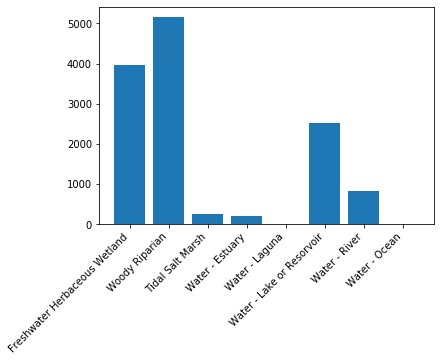

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(value_count)), list(value_count.values()), align='center')
plt.xticks(range(len(value_count)), list(value_count.keys()), rotation=45, ha="right")
plt